# Подготовка данных

## Импорт библиотек

In [1]:
import os
import random
from collections import Counter, defaultdict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from itertools import zip_longest
from typing import Dict, List, Tuple
import math
from collections import defaultdict
from typing import List, Tuple, Optional, Dict
import time
import zipfile

### Настройки

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/archive-3.zip", "r") as zip_ref:
    zip_ref.extractall("archive-3")

In [4]:
LFW_DIR = "archive-3/archive-3/lfw-deepfunneled/lfw-deepfunneled"

## Формирование датасета

In [5]:
def list_people_and_images_recursive(root: str):
    person_to_imgs = {}
    for dirpath, dirnames, filenames in os.walk(root):
        img_files = [f for f in filenames if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if img_files:
            person_name = os.path.basename(dirpath)
            full_paths = [os.path.join(dirpath, f) for f in img_files]
            person_to_imgs.setdefault(person_name, []).extend(full_paths)
    return person_to_imgs

person_to_imgs = list_people_and_images_recursive(LFW_DIR)

rows = []
for person, imgs in person_to_imgs.items():
    for p in imgs:
        rows.append({"person": person, "image_path": p})
df = pd.DataFrame(rows)

In [6]:
df

,person,image_path
0,Pat_DAmuro,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
1,Paul-Henri_Mathieu,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
2,Paul-Henri_Mathieu,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
3,Paul-Henri_Mathieu,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
4,Esther_Macklin,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
...,...,...
13228,Stephen_Ambrose,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
13229,Stephen_Ambrose,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
13230,Asa_Hutchinson,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...
13231,Asa_Hutchinson,archive-3/archive-3/lfw-deepfunneled/lfw-deepf...


## Анализ датасета

### Оценка размеров изображений

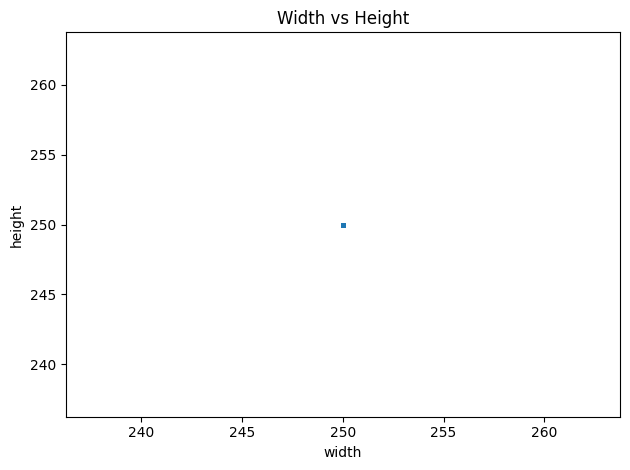

In [7]:
def compute_image_sizes(df: pd.DataFrame, sample_limit: int = None):
    paths = df["image_path"].tolist()
    if sample_limit:
        paths = paths[:sample_limit]
    sizes = []
    rows = []
    for p in paths:
        try:
            with Image.open(p) as im:
                w, h = im.size
        except Exception:
            continue
        sizes.append((w, h))
        rows.append({"image_path": p, "width": w, "height": h})
    sizes = np.array(sizes, dtype=int) if sizes else np.empty((0,2), dtype=int)
    df_sizes = pd.DataFrame(rows)
    return sizes, df_sizes

def plot_size_distributions(sizes: np.ndarray, bins: int = 40):
    if sizes.size == 0:
        print("No sizes to plot")
        return
    widths = sizes[:,0]
    heights = sizes[:,1]

    plt.subplot(1, 1, 1)
    plt.scatter(widths, heights, s=6, alpha=0.25)
    plt.xlabel("width")
    plt.ylabel("height")
    plt.title("Width vs Height")
    plt.tight_layout()
    plt.show()

sizes, df_sizes = compute_image_sizes(df, sample_limit=None)
plot_size_distributions(sizes)

### Топ 10 и лоу 10 по количеству фото на человека

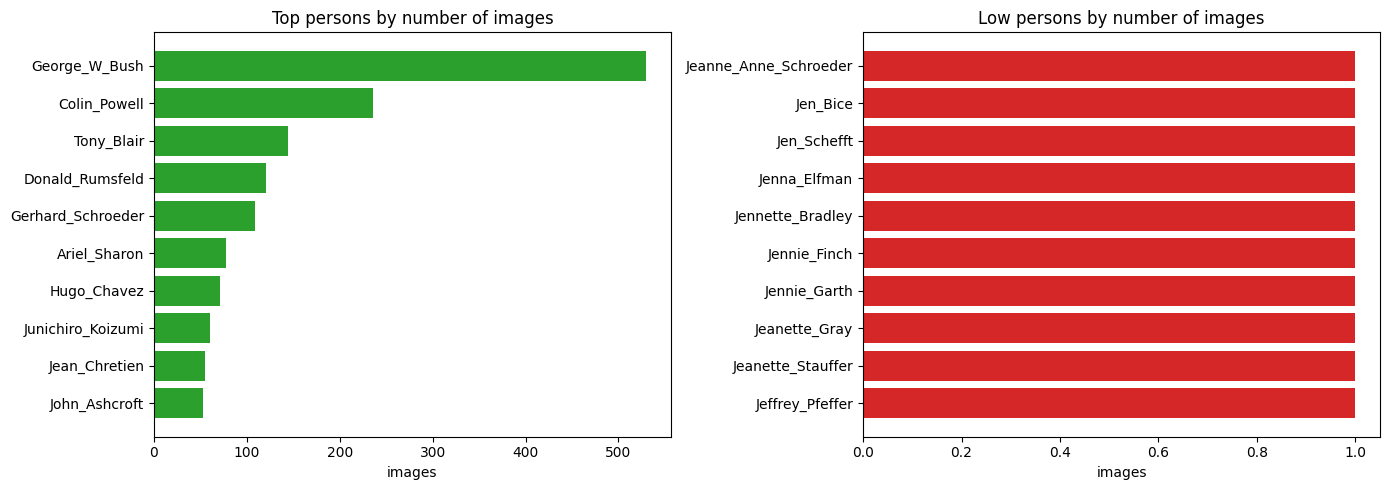

In [8]:
def top_and_low_counts(df: pd.DataFrame, top_k: int = 10):
    counts = df.groupby("person")["image_path"].agg(list).reset_index()
    counts["n_images"] = counts["image_path"].apply(len)
    counts["example"] = counts["image_path"].apply(lambda lst: lst[0] if lst else None)
    counts_sorted = counts.sort_values("n_images", ascending=False).reset_index(drop=True)
    top = counts_sorted.head(top_k).copy()
    low = counts_sorted.tail(top_k).sort_values("n_images", ascending=True).reset_index(drop=True)
    return top, low

def plot_top_low(top: pd.DataFrame, low: pd.DataFrame):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.barh(top["person"].iloc[::-1], top["n_images"].iloc[::-1], color="tab:green")
    plt.title("Top persons by number of images")
    plt.xlabel("images")
    plt.subplot(1,2,2)
    plt.barh(low["person"].iloc[::-1], low["n_images"].iloc[::-1], color="tab:red")
    plt.title("Low persons by number of images")
    plt.xlabel("images")
    plt.tight_layout()
    plt.show()

top10, low10 = top_and_low_counts(df, top_k=10)
plot_top_low(top10, low10)

### Визуализация случайных фото

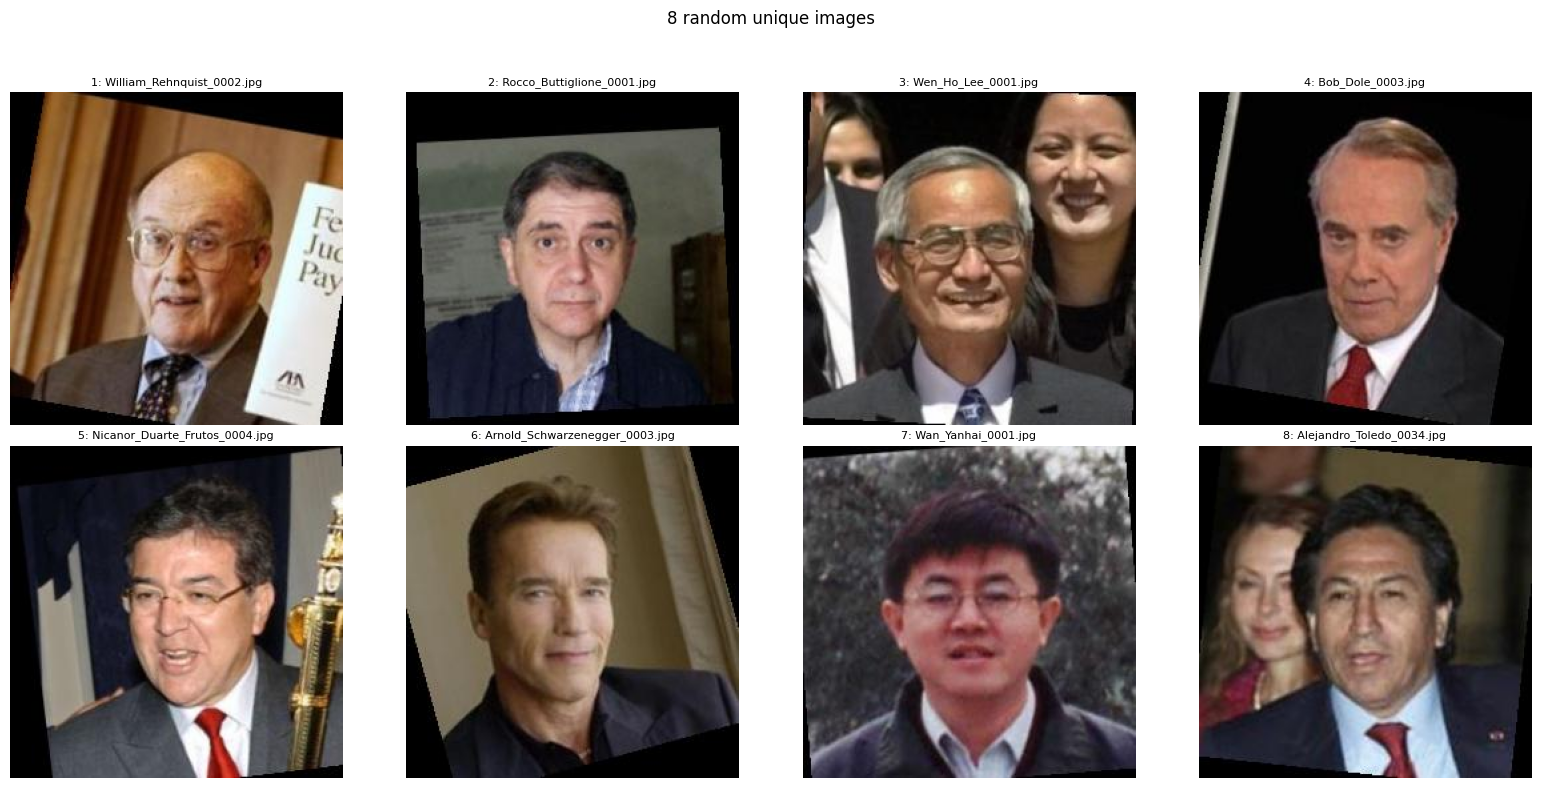

In [9]:
def show_random_unique_img(df: pd.DataFrame, n_images: int = 10, column = 4, figsize_per_image = 4):
    available = df["image_path"].dropna().unique().tolist()
    n = min(n_images, len(available))
    sampled = random.sample(available, n)

    cols = min(column, n)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * figsize_per_image, rows * figsize_per_image))

    for i, img_path in enumerate(sampled, start=1):
        ax = plt.subplot(rows, cols, i)
        try:
            img = Image.open(img_path).convert("RGB")
            ax.imshow(img)
        except Exception:
            ax.text(0.5, 0.5, "Error", ha="center", va="center")
        ax.set_title(f"{i}: {img_path.split('/')[-1]}", fontsize=8)
        ax.axis("off")

    plt.suptitle(f"{n} random unique images", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

show_random_unique_img(df, n_images=8)

### Визуализация позитивной пары (одинаковые люди)

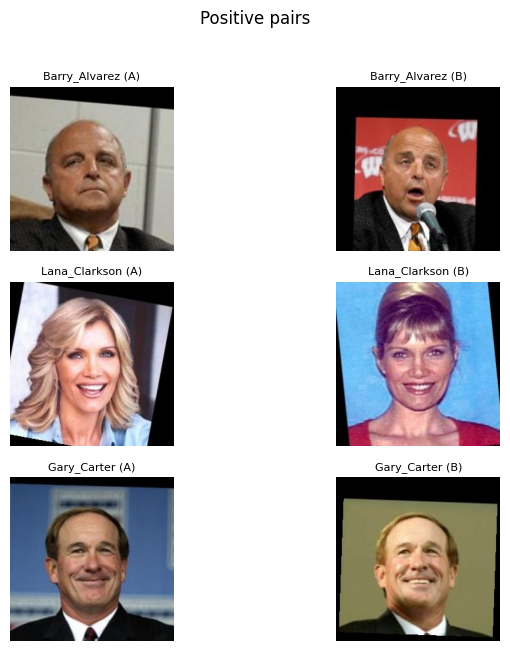

In [10]:
def show_positive_pairs(df: pd.DataFrame, n_pairs: int = 8):
    persons_with_2plus = df.groupby("person").filter(lambda g: len(g) >= 2)["person"].unique().tolist()
    pairs = []
    for _ in range(n_pairs):
        p = random.choice(persons_with_2plus)
        imgs = df[df["person"] == p]["image_path"].tolist()
        a, b = random.sample(imgs, 2)
        pairs.append((a, b, p))
    rows = len(pairs)
    plt.figure(figsize=(8, rows*2.2))
    for i, (a, b, pname) in enumerate(pairs):
        ax1 = plt.subplot(rows, 2, 2*i + 1)
        ax2 = plt.subplot(rows, 2, 2*i + 2)
        ax1.imshow(Image.open(a).convert("RGB")); ax1.axis("off"); ax1.set_title(f"{pname} (A)", fontsize=8)
        ax2.imshow(Image.open(b).convert("RGB")); ax2.axis("off"); ax2.set_title(f"{pname} (B)", fontsize=8)
    plt.suptitle("Positive pairs")
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

show_positive_pairs(df, n_pairs=3)

### Визуализация негативной пары (разные люди)

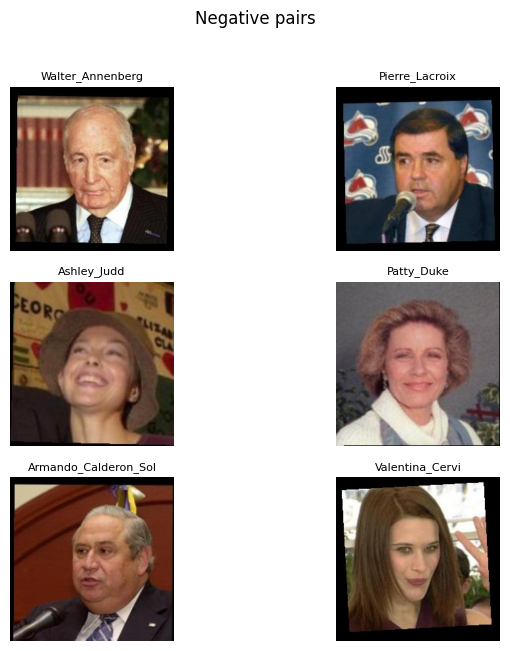

In [11]:
def show_negative_pairs(df: pd.DataFrame, n_pairs: int = 8):
    persons = df["person"].unique().tolist()
    pairs = []
    for _ in range(n_pairs):
        p1, p2 = random.sample(persons, 2)
        a = random.choice(df[df["person"] == p1]["image_path"].tolist())
        b = random.choice(df[df["person"] == p2]["image_path"].tolist())
        pairs.append((a, b, p1, p2))
    rows = len(pairs)
    plt.figure(figsize=(8, rows*2.2))
    for i, (a, b, p1, p2) in enumerate(pairs):
        ax1 = plt.subplot(rows, 2, 2*i + 1)
        ax2 = plt.subplot(rows, 2, 2*i + 2)
        ax1.imshow(Image.open(a).convert("RGB")); ax1.axis("off"); ax1.set_title(p1, fontsize=8)
        ax2.imshow(Image.open(b).convert("RGB")); ax2.axis("off"); ax2.set_title(p2, fontsize=8)
    plt.suptitle("Negative pairs")
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

show_negative_pairs(df, n_pairs=3)

# Подготовка к обучению

## Импорт библиотек

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import torch

class LFWDatasetPairs(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform or T.ToTensor()
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        p1,p2,label = self.pairs[idx]
        img1 = Image.open(p1).convert("RGB")
        img2 = Image.open(p2).convert("RGB")
        if self.transform:
            img1 = self.transform(img1); img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
import torch
import torchvision.transforms as T

## Параметры

In [14]:
IMG_SIZE = 150
BATCH_SIZE = 64
EMBED_DIM = 128
LR = 1e-4
NUM_NEG_PER_POS = 1
MARGIN = 1.0
SEED = 42
DELIM = 6
# MPS на Mac M1
if torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
torch.manual_seed(SEED)


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

cuda


## Формирования выборок

In [15]:
train_frac, val_frac, test_frac = 0.8, 0.1, 0.1

all_persons = sorted(df["person"].unique().tolist())

rng = np.random.default_rng(SEED)
n_total = len(all_persons)
n_keep = max(1, n_total // DELIM)
keep_idx = rng.choice(n_total, size=n_keep, replace=False)
persons_half = [all_persons[i] for i in sorted(keep_idx)]

rng.shuffle(persons_half)

n = len(persons_half)
i1 = int(train_frac * n)
i2 = i1 + int(val_frac * n)

train_p = persons_half[:i1]
val_p = persons_half[i1:i2]
test_p = persons_half[i2:]

if len(train_p) == 0 and n > 0:
    train_p = persons_half[:1]
    val_p = persons_half[1:2] if n > 1 else []
    test_p = persons_half[2:] if n > 2 else []

train_df = df[df["person"].isin(train_p)].reset_index(drop=True)
val_df   = df[df["person"].isin(val_p)].reset_index(drop=True)
test_df  = df[df["person"].isin(test_p)].reset_index(drop=True)

print("Persons: total (original)", n_total, "kept", n, "train", len(train_p), "val", len(val_p), "test", len(test_p))
print("Images: train", len(train_df), "val", len(val_df), "test", len(test_df))

Persons: total (original) 5749 kept 958 train 766 val 95 test 97
Images: train 1780 val 159 test 204


### Формирование пар

In [16]:
def make_pairs_from_df(df: pd.DataFrame, person_to_imgs_map: dict, num_neg_per_pos: int = 1) -> List[Tuple[str,str,int]]:
    persons = df["person"].unique().tolist()
    pos_pairs = []
    for p in persons:
        imgs = person_to_imgs_map[p]
        if len(imgs) >= 2:
            for i in range(len(imgs)):
                for j in range(i+1, len(imgs)):
                    pos_pairs.append((imgs[i], imgs[j], 1))

    neg_pairs = []
    all_persons = persons
    for (a, b, _) in pos_pairs:
        for _ in range(num_neg_per_pos):
            while True:
                other = random.choice(all_persons)
                if other != os.path.basename(os.path.dirname(a)):
                    break
            img2 = random.choice(person_to_imgs_map[other])
            neg_pairs.append((a, img2, 0))

    pairs = pos_pairs + neg_pairs
    random.shuffle(pairs)
    return pairs

train_pairs = make_pairs_from_df(train_df, person_to_imgs, num_neg_per_pos=NUM_NEG_PER_POS)
val_pairs   = make_pairs_from_df(val_df,   person_to_imgs, num_neg_per_pos=NUM_NEG_PER_POS)
test_pairs  = make_pairs_from_df(test_df,  person_to_imgs, num_neg_per_pos=NUM_NEG_PER_POS)

print("Pairs generated: train", len(train_pairs), "val", len(val_pairs), "test", len(test_pairs))

Pairs generated: train 27998 val 338 test 1354


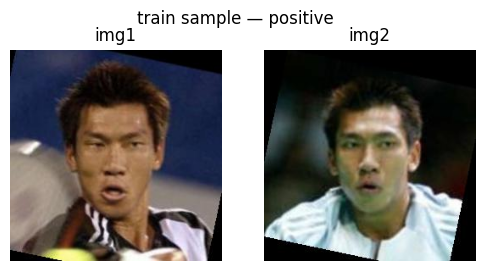

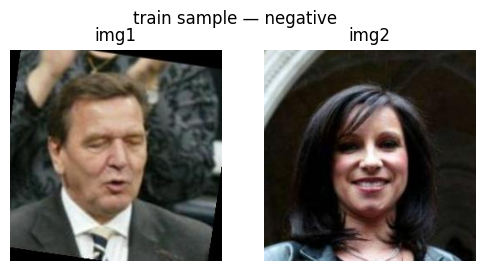

In [17]:
def show_one_pos_and_neg(pairs, title="sample"):
    pos = None
    neg = None
    for a, b, label in pairs:
        if label == 1 and pos is None:
            pos = (a, b)
        if label == 0 and neg is None:
            neg = (a, b)
        if pos is not None and neg is not None:
            break

    def show_pair(pair, ax_row_title):
        p1, p2 = pair
        img1 = Image.open(p1).convert("RGB")
        img2 = Image.open(p2).convert("RGB")
        fig, axes = plt.subplots(1,2, figsize=(6,3))
        axes[0].imshow(img1); axes[0].axis("off"); axes[0].set_title("img1")
        axes[1].imshow(img2); axes[1].axis("off"); axes[1].set_title("img2")
        fig.suptitle(f"{title} — {ax_row_title}")
        plt.show()

    show_pair(pos, "positive")
    show_pair(neg, "negative")

show_one_pos_and_neg(train_pairs, title="train sample")

### Реализация обучающей, тестовой и валидационной выборок

In [18]:
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.05,0.05,0.05,0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

eval_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = LFWDatasetPairs(train_pairs, transform=train_transform)
val_ds   = LFWDatasetPairs(val_pairs,   transform=eval_transform)
test_ds  = LFWDatasetPairs(test_pairs,  transform=eval_transform)


train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=8, persistent_workers=True, prefetch_factor=3, pin_memory=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=8, persistent_workers=True, prefetch_factor=3, pin_memory=False
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=8, persistent_workers=True, prefetch_factor=3, pin_memory=False
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Обучение модели

## Импорт библиотек

In [19]:
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import roc_curve, auc

## Параметры

In [20]:
EPOCHS = 10

## Формирование модели

In [21]:
ResNet18_Weights = models.ResNet18_Weights

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=EMBED_DIM, pretrained=True):
        super().__init__()
        if pretrained and ResNet18_Weights is not None:
            back = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        elif pretrained and ResNet18_Weights is None:
            back = models.resnet18(pretrained=True)
        else:
            back = models.resnet18(weights=None)

        modules = list(back.children())[:-1]
        self.backbone = nn.Sequential(*modules)
        self.fc = nn.Linear(back.fc.in_features, embedding_dim)
        self.bn = nn.BatchNorm1d(embedding_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.flatten(1)
        x = self.fc(x)
        x = self.bn(x)
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        return self.embedding_net(x1), self.embedding_net(x2)


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=MARGIN):
        super().__init__()
        self.margin = margin

    def forward(self, e1, e2, label):
        distances = torch.norm(e1 - e2, p=2, dim=1)
        loss_pos = label * (distances ** 2)
        loss_neg = (1.0 - label) * torch.clamp(self.margin - distances, min=0.0) ** 2
        loss = torch.mean(loss_pos + loss_neg)
        return loss, distances

embedding_net = EmbeddingNet(embedding_dim=EMBED_DIM, pretrained=True)
model = SiameseNet(embedding_net).to(DEVICE)


model = model.to(memory_format=torch.channels_last)

criterion = ContrastiveLoss(margin=MARGIN)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


### Сохранение весов

In [22]:
CHECKPOINT_DIR = os.environ.get("CHECKPOINT_DIR", "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
save_every = int(os.environ.get("SAVE_EVERY", 1))

autocast_kwargs = dict(device_type="mps", dtype=torch.float16, enabled=(DEVICE == "mps"))

def save_checkpoint(path, model, optimizer=None, scheduler=None, epoch=None, metrics=None):
    tmp_path = path + ".tmp"
    ckpt = {"model_state_dict": model.state_dict()}
    if optimizer is not None:
        ckpt["optimizer_state_dict"] = optimizer.state_dict()
    if scheduler is not None:
        try:
            ckpt["scheduler_state_dict"] = scheduler.state_dict()
        except Exception:
            pass
    if epoch is not None:
        ckpt["epoch"] = epoch
    if metrics is not None:
        ckpt["metrics"] = metrics
    torch.save(ckpt, tmp_path)
    os.replace(tmp_path, path)

### Формирование процесса обучения

In [23]:
def compute_metrics_from_dists(dists, labels):
    scores = -dists
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[idx]
    thr = thresholds[idx]
    return {"auc": roc_auc, "eer": eer, "threshold": thr, "fpr": fpr, "tpr": tpr}

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    dists_list = []
    labels_list = []

    for x1, x2, label in tqdm(loader, desc="Train", leave=False):
        x1 = x1.to(device, memory_format=torch.channels_last, non_blocking=False)
        x2 = x2.to(device, memory_format=torch.channels_last, non_blocking=False)
        lbl = label.view(-1).to(device, dtype=torch.float32)

        optimizer.zero_grad()

        with torch.autocast(**autocast_kwargs):
            e1, e2 = model(x1, x2)
            loss, dists = criterion(e1, e2, lbl)

        loss.backward()
        optimizer.step()

        running_loss += loss.detach() * x1.size(0)
        dists_list.append(dists.detach())
        labels_list.append(lbl.detach())

    epoch_loss = (running_loss / len(loader.dataset)).item()
    all_dists = torch.cat(dists_list).cpu().numpy()
    all_labels = torch.cat(labels_list).cpu().numpy()
    return epoch_loss, all_dists, all_labels

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    dists_list = []
    labels_list = []

    with torch.no_grad():
        for x1, x2, label in tqdm(loader, desc="Eval", leave=False):
            x1 = x1.to(device, memory_format=torch.channels_last, non_blocking=False)
            x2 = x2.to(device, memory_format=torch.channels_last, non_blocking=False)
            lbl = label.view(-1).to(device, dtype=torch.float32)

            with torch.autocast(**autocast_kwargs):
                e1, e2 = model(x1, x2)
                loss, dists = criterion(e1, e2, lbl)

            running_loss += loss.detach() * x1.size(0)
            dists_list.append(dists.detach())
            labels_list.append(lbl.detach())

    epoch_loss = (running_loss / len(loader.dataset)).item()
    all_dists = torch.cat(dists_list).cpu().numpy()
    all_labels = torch.cat(labels_list).cpu().numpy()
    return epoch_loss, all_dists, all_labels


history = defaultdict(list)
best_val_auc = 0.0

_required = ["model", "train_loader", "val_loader", "optimizer", "scheduler", "criterion", "DEVICE", "EPOCHS"]
_missing = [name for name in _required if name not in globals()]
if _missing:
    raise RuntimeError(f"Missing required globals before training: {_missing}")

## Обучение модели

In [24]:
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    print(f"Epoch {epoch}/{EPOCHS}")
    train_loss, train_dists, train_labels = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_dists, val_labels = evaluate(model, val_loader, criterion, DEVICE)

    train_metrics = compute_metrics_from_dists(train_dists, train_labels)
    val_metrics = compute_metrics_from_dists(val_dists, val_labels)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_auc'].append(train_metrics['auc'])
    history['val_auc'].append(val_metrics['auc'])
    history['train_eer'].append(train_metrics['eer'])
    history['val_eer'].append(val_metrics['eer'])

    print(f"  train_loss: {train_loss:.4f}  train_auc: {train_metrics['auc']:.4f}  train_eer: {train_metrics['eer']:.4f}")
    print(f"  val_loss:   {val_loss:.4f}    val_auc:   {val_metrics['auc']:.4f}    val_eer:   {val_metrics['eer']:.4f}")

    if epoch % save_every == 0:
        path = os.path.join(CHECKPOINT_DIR, f"epoch_{epoch}.pth")
        save_checkpoint(path, model, optimizer, scheduler, epoch=epoch,
                        metrics={"val_auc": val_metrics['auc'], "val_eer": val_metrics['eer']})
        print(f"  Saved periodic checkpoint: {path}")

    if val_metrics['auc'] > best_val_auc:
        best_val_auc = val_metrics['auc']
        path = os.path.join(CHECKPOINT_DIR, "best_checkpoint.pth")
        save_checkpoint(path, model, optimizer, scheduler, epoch=epoch,
                        metrics={"val_auc": val_metrics['auc'], "val_eer": val_metrics['eer']})
        print("  Saved best checkpoint")

    scheduler.step()
    print(f"  epoch time: {time.time()-t0:.1f}s\n")

try:
    import json
    with open(os.path.join(CHECKPOINT_DIR, "history.json"), "w") as fh:
        json.dump({k: list(v) for k, v in history.items()}, fh)
    print(f"Saved training history to {os.path.join(CHECKPOINT_DIR, 'history.json')}")
except Exception:
    pass

Epoch 1/10


Train:   0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  train_loss: 0.1133  train_auc: 0.9600  train_eer: 0.1035
  val_loss:   0.2964    val_auc:   0.8309    val_eer:   0.2485
  Saved periodic checkpoint: checkpoints/epoch_1.pth
  Saved best checkpoint
  epoch time: 229.7s

Epoch 2/10


  train_loss: 0.0233  train_auc: 0.9974  train_eer: 0.0196
  val_loss:   0.2141    val_auc:   0.8757    val_eer:   0.2130
  Saved periodic checkpoint: checkpoints/epoch_2.pth
  Saved best checkpoint
  epoch time: 223.0s

Epoch 3/10


  train_loss: 0.0159  train_auc: 0.9989  train_eer: 0.0116
  val_loss:   0.1671    val_auc:   0.9062    val_eer:   0.1893
  Saved periodic checkpoint: checkpoints/epoch_3.pth
  Saved best checkpoint
  epoch time: 226.9s

Epoch 4/10


  train_loss: 0.0107  train_auc: 0.9993  train_eer: 0.0071
  val_loss:   0.1587    val_auc:   0.9215    val_eer:   0.1420
  Saved periodic checkpoint: checkpoints/epoch_4.pth
  Saved best checkpoint
  epoch time: 223.3s

Epoch 5/10


  train_loss: 0.0092  train_auc: 0.9995  train_eer: 0.0058
  val_loss:   0.1687    val_auc:   0.9171    val_eer:   0.1657
  Saved periodic checkpoint: checkpoints/epoch_5.pth
  epoch time: 220.7s

Epoch 6/10


  train_loss: 0.0076  train_auc: 0.9995  train_eer: 0.0050
  val_loss:   0.1661    val_auc:   0.9260    val_eer:   0.1420
  Saved periodic checkpoint: checkpoints/epoch_6.pth
  Saved best checkpoint
  epoch time: 228.5s

Epoch 7/10


  train_loss: 0.0058  train_auc: 0.9996  train_eer: 0.0028
  val_loss:   0.1774    val_auc:   0.9205    val_eer:   0.1479
  Saved periodic checkpoint: checkpoints/epoch_7.pth
  epoch time: 220.8s

Epoch 8/10


  train_loss: 0.0048  train_auc: 0.9996  train_eer: 0.0023
  val_loss:   0.1530    val_auc:   0.9276    val_eer:   0.1183
  Saved periodic checkpoint: checkpoints/epoch_8.pth
  Saved best checkpoint
  epoch time: 221.3s

Epoch 9/10


  train_loss: 0.0043  train_auc: 0.9997  train_eer: 0.0019
  val_loss:   0.1364    val_auc:   0.9311    val_eer:   0.1302
  Saved periodic checkpoint: checkpoints/epoch_9.pth
  Saved best checkpoint
  epoch time: 221.4s

Epoch 10/10


  train_loss: 0.0043  train_auc: 0.9997  train_eer: 0.0016
  val_loss:   0.1793    val_auc:   0.9294    val_eer:   0.1302
  Saved periodic checkpoint: checkpoints/epoch_10.pth
  epoch time: 221.7s

Saved training history to checkpoints/history.json


# Оценка работы модели

## Параметры

In [25]:
THRESHOLD = 0.5

## Построение ROC‑кривой

Test results
  loss: 0.1940
  AUC:  0.8836
  EER:  0.1950
  threshold (EER): -0.7256


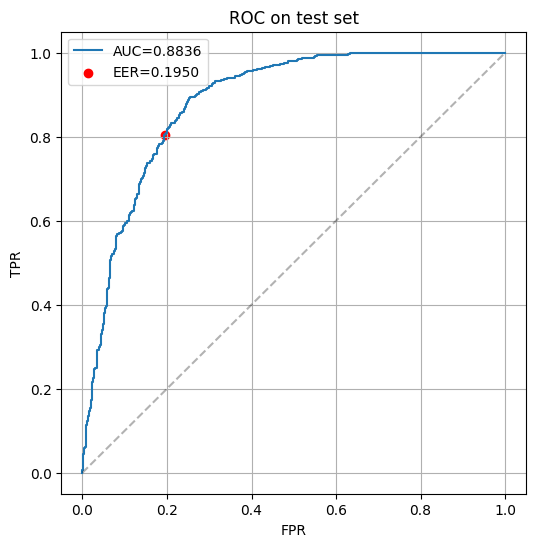

In [30]:
best_checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_checkpoint.pth")
checkpoint = torch.load(best_checkpoint_path, weights_only=False, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_dists, test_labels = evaluate(model, test_loader, criterion, DEVICE)
test_metrics = compute_metrics_from_dists(test_dists, test_labels)

print("Test results")
print(f"  loss: {test_loss:.4f}")
print(f"  AUC:  {test_metrics['auc']:.4f}")
print(f"  EER:  {test_metrics['eer']:.4f}")
print(f"  threshold (EER): {test_metrics['threshold']:.4f}")

plt.figure(figsize=(6,6))
plt.plot(test_metrics['fpr'], test_metrics['tpr'], label=f"AUC={test_metrics['auc']:.4f}")
plt.plot([0,1],[0,1],'k--', alpha=0.3)
plt.scatter([test_metrics['eer']], [1 - test_metrics['eer']], c='r', label=f"EER={test_metrics['eer']:.4f}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC on test set")
plt.legend()
plt.grid(True)
plt.show()

## История обучения

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.plot(epochs, history['train_loss'], '-o', label='train_loss')
    plt.plot(epochs, history['val_loss'], '-o', label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,3,2)
    plt.plot(epochs, history['train_auc'], '-o', label='train_auc')
    plt.plot(epochs, history['val_auc'], '-o', label='val_auc')
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("AUC")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,3,3)
    plt.plot(epochs, history['train_eer'], '-o', label='train_eer')
    plt.plot(epochs, history['val_eer'], '-o', label='val_eer')
    plt.xlabel("Epoch")
    plt.ylabel("EER")
    plt.title("EER")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Визуализация прогноза модели с фото

In [ ]:

def show_test_pairs(pairs_list, model, transform=None, device=DEVICE, n=8, seed=42, threshold: float = 0.65):
    random.seed(seed)
    sample = random.sample(pairs_list, min(n, len(pairs_list)))
    k = len(sample)
    plt.figure(figsize=(9, 3*k))

    results = []
    model.eval()
    for i, (p1, p2, lbl) in enumerate(sample):
        img1 = Image.open(p1).convert("RGB")
        img2 = Image.open(p2).convert("RGB")

        t1 = transform(img1).unsqueeze(0).to(device)
        t2 = transform(img2).unsqueeze(0).to(device)
        try:
            t1 = t1.to(memory_format=torch.channels_last)
            t2 = t2.to(memory_format=torch.channels_last)
        except Exception:
            pass

        with torch.no_grad():
            with torch.autocast(**autocast_kwargs):
                e1 = model.embedding_net(t1) if hasattr(model, "embedding_net") else model(t1)
                e2 = model.embedding_net(t2) if hasattr(model, "embedding_net") else model(t2)
                dist = float(torch.norm(e1 - e2, p=2).item())

        match = dist < threshold

        ax1 = plt.subplot(k, 3, i*3 + 1)
        ax1.imshow(img1); ax1.axis("off"); ax1.set_title("img1")
        ax2 = plt.subplot(k, 3, i*3 + 2)
        ax2.imshow(img2); ax2.axis("off"); ax2.set_title("img2")
        ax3 = plt.subplot(k, 3, i*3 + 3)
        ax3.text(0.5, 0.5, f"label={lbl}\ndist={dist:.4f}\nmatch={match}", ha='center', va='center', fontsize=11)
        ax3.axis("off")

        results.append({"path1": p1, "path2": p2, "label": lbl, "dist": dist, "match": match})

    plt.tight_layout()
    plt.show()
    return results

res = show_test_pairs(test_pairs, model, transform=eval_transform, device=DEVICE, n=10, threshold=THRESHOLD)